In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/healthinsurance/Health_insurance.csv


## 0. Helper functions

In [2]:
### NIKLAS' HELPER FUNCTIONS (copied from Costa Rica 2)


## CATEGORIES
# Dealing with categorical variables I: during data prep
def train_cats(df, max_card=0, dep_var=None):
    """
    Turns all string variables in df into categorical variables
    optional parameters:
    - max_card: also turns integer variables into categorical variables, when there are at most max_card different values in a given column
    - dep_var: ingore the dependent variable in the processing
    Output: a dataset, in which all string variables (and - if max_card is used - integers with a cardinality <= max_card) have been turned into categories.
    Categorical variables still need to be turned into numbers before feeding the data to a model. This can be done using the function numericalise_cats()
    """
    for n,c in df.items(): # n is the name of the column, c is the series
        if n == dep_var: continue
        if pd.api.types.is_string_dtype(df[n]) or (pd.api.types.is_integer_dtype(df[n]) and df[n].unique().shape[0] <= max_card): 
            df[n] = df[n].astype('category').cat.as_ordered()

def apply_cats(df, trn):
    """ 
    Transforms the test set to have the same categorical variables (and category codes) as the training set.
    Output: a dataset, in which all string variables (and - if max_card is used - integers with a cardinality <= max_card) have been turned into categories.
    Categorical variables still need to be turned into numbers before feeding the data to a model.
    """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n] = df[n].cat.set_categories(trn[n].cat.categories, ordered=True)
            
# Dealing with categorical variables II: just before sending the data to the model            
def numericalise_cats(df):
    """
    Transforms categorical into numerical columns
    Returns a dictionary of dictionaries. In the big dictionary, each dictinary:
        is named like the categorical variable, which has been transformed into numerical.
        contains the mapping: left the new numerical variable, right the original category
    """
    dictionary = {}
    for c in df.columns:
        if df[c].dtype.name == 'category':
            # create the dictionary of mapping (https://stackoverflow.com/questions/30510562/get-mapping-of-categorical-variables-in-pandas)        
            mapping = dict( enumerate(df[c].cat.categories ) )
            dictionary[c] = mapping
            # transform the categorical variable into a numerical variable
            df[c] = df[c].cat.codes
    return dictionary
    
# Dealing with categorical variables: helper function
    # just print out lists: which variables are categorical and which ones are not
    # use cont_cat_split(df_train, max_card=0, dep_var='Target') from the fastai.tabular.all Class
    #from fastai.tabular.all import *
    #cont_cat_split(df_train, max_card=0, dep_var='Target')

## DATES
# Deal with dates
  #  use add_datepart() from the fastai.Tabular class. 
  #  by default add_datepart() also removes the data column, so it does not need to be removed before passing it onto the model
# to add for future use: add_datepart() does not deal with missings https://stackoverflow.com/questions/43889611/median-of-panda-datetime64-column

## MISSING VALLUES
# Deal with missing values

# in the training set
def train_missings(df):
    """
    For each NUMERICAL variable with missing values, creates a column to indicate observations which had a missing value in this column.
    Then fills in the missing values with the column median. 
    Returns a dictionary with an entry for each column that had a missing, indicating the value which was filled in.
    """
    #  create an indicator when the column has missing values
    nas = {}
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]) == False: continue # skip a column if it is not numerical
        if df[col].isnull().sum() > 0: # if the are missing values in the column
            df[str(col)+'_isna'] = df[col].isnull().astype(int) # create an indicator variable (equal 1 if the value is missing for the given observation)
            df[col].fillna(df[col].median(),inplace=True) # fill in with median
            nas[col] = df[col].median() # add to the dictionary of filled in values
    return nas
    #  fill with the median 
    #  return a dictionary of (1) the variables where missing values where filled and (2) the value which was filled in
  # as features:
    #  only create the indicator when a variable is missing and return a list of the columns which have missing values

# in the test set
def apply_missings(df, trn_dict, fill_other_missings=False):
    # apply_missings(df, trn_dict, fill_other_missings=False)
        # take a dataframe and a dictionary of columns and a fill value for each column
        # for each entry in the dictionary, create an indicator variable
        # for each entry in the dictionary, fill any missing observations with the value in the dictionary
        # optional: if there are remaining variables which have missing values, then fill them with the median (without creating a missing variable)
    """
    For each variable in the dictionary, creates a column to indicate observations which had a missing value in this column.
    Then fills in the missing values with the value from the dictionary. 
    If fill_other_missings=True, then also fills in all other missing values (with the median of the dataset), but without creating an additional column.
    """ 
    for col, na_value in trn_dict.items(): 
        df[str(col)+'_isna'] = df[col].isnull().astype(int) # create an indicator variable (equal 1 if the value is missing for the given observation)
        df[col].fillna(na_value,inplace=True) # fill in missings with the value from the dictionary (change na_value to df[col].median() to fill in the median instead)
    if fill_other_missings==True:
        for col in detect_missings(df):
            df[col].fillna(df[col].median(),inplace=True) # fill in missings with median

            # helper function            
def detect_missings(df):
    # detect_missings(df)
    # return a list of all columns which have missing variables
    """
    Returns a list with all columns which have missing values
    """
    missings = []
    for col in df.columns:
        if df[col].isnull().sum() > 0: missings.append(col)
    return missings

In [3]:
df_train = pd.read_csv('../input/healthinsurance/Health_insurance.csv')

In [4]:
train_cats(df_train)
nas = train_missings(df_train)
translation = numericalise_cats(df_train)

## 1. Building (a good) random forest

#### 1.1 just check everything works

In [5]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

m = RandomForestRegressor(n_jobs=-1)
# m = RandomForestRegressor(n_estimators=100, max_depth=5, bootstrap=True, n_jobs=-1, oob_score=True)

%time m.fit(df_train.drop(['charges'], axis=1), df_train.charges)
m.score(df_train.drop(['charges'], axis=1), df_train.charges)

CPU times: user 510 ms, sys: 43.6 ms, total: 553 ms
Wall time: 361 ms


0.9765906996568695

#### 1.2 do it properly: test and validation set

In [6]:
# define a function to easily evaluate the performance of a random forest
def print_score(m):
    res = [m.score(df_tra.drop(['charges'], axis=1), df_tra.charges), m.score(df_val.drop(['charges'], axis=1), df_val.charges)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [7]:
# split into training and validation set

# 1ST FIRST APPROACH: MANUALLY
print(df_train.info())
def split_vals(a,n): return a[:n].copy(), a[n:].copy()
df_tra, df_val = split_vals(df_train, 1050)
X_tra = df_tra.drop(['charges'], axis=1)
y_tra = df_tra['charges']
X_val = df_val.drop(['charges'], axis=1)
y_val = df_val['charges']

# 2ND APPROACH: USING SKLEARN
#from sklearn.model_selection import train_test_split 
#X_tra, X_val, y_tra, y_val = train_test_split(df_train.drop(['charges'], axis=1), df_train.charges, test_size=0.2, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int8   
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int8   
 5   region    1338 non-null   int8   
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), int8(3)
memory usage: 45.9 KB
None


In [8]:
# Now train a forest on the training data and measure its performance on the validation data

m.fit(df_tra.drop(['charges'], axis=1), df_tra.charges)

print_score(m) # we are overfitting badly: there is quite a difference between training and validation set

[0.9757428394516634, 0.8486700300564454]


In [9]:
m.get_params() # get the hyperparameters of the trained model

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### 1.3 Tune parameters

##### 1.3.a Motivation/Just for fun: how many trees should the forest have?

In [10]:
m.estimators_[0].predict(df_val.drop(['charges'], axis=1)).shape

(288,)

In [11]:
preds = np.stack([t.predict(df_val.drop(['charges'], axis=1)) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), df_val.charges.iloc[0]

(array([ 7731.85785,  7152.6714 ,  7421.19455,  7518.02535,  7345.7266 ,
         6948.7008 , 12797.20962, 12797.20962, 12797.20962,  7740.337  ,
         7152.6714 ,  7731.85785,  7421.19455,  7152.6714 ,  8116.26885,
         6948.7008 ,  7731.85785,  7345.7266 ,  6948.7008 , 28476.73499,
         7633.7206 , 12797.20962, 12797.20962,  7152.6714 ,  7152.6714 ,
         8823.98575, 12797.20962, 19144.57652, 12797.20962,  7731.85785,
         7935.29115, 12797.20962, 28340.18885, 12797.20962,  8569.8618 ,
         7421.19455,  7152.6714 ,  6948.7008 ,  7633.7206 ,  7152.6714 ,
         7633.7206 ,  7152.6714 ,  9704.66805,  6948.7008 ,  9704.66805,
         7633.7206 ,  7443.64305, 12797.20962, 12797.20962,  7152.6714 ,
        28468.91901,  7443.64305,  7731.85785,  7358.17565, 11033.6617 ,
         6948.7008 ,  7152.6714 ,  7731.85785, 12797.20962, 28468.91901,
         7265.7025 , 28468.91901,  7633.7206 ,  7740.337  ,  7731.85785,
         8116.26885,  7740.337  ,  7345.7266 , 1279

In [12]:
preds.shape

(100, 288)

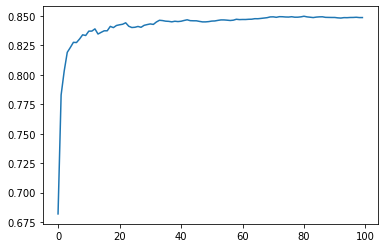

In [13]:
import matplotlib.pyplot as plt
from sklearn import metrics
plt.plot([metrics.r2_score(y_val, np.mean(preds[:i+1], axis=0)) for i in range(100)]);

##### 1.3.b Now do the tuning properly: GridSearch and Randomized Search

In [14]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### CREATE THE GRID

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 30, num = 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10, 15, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the grid
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [15]:
### RANDOM SEARCH

# specify the model to tune and the search to perform
rf = RandomForestRegressor() # model to tune
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = grid, n_iter = 200, cv = 5, random_state=42, n_jobs = -1) # search across 200 different combinations

# conduct the search: fit the model
rf_random.fit(df_train.drop(['charges'], axis=1), df_train.charges)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10, 15,
                                                             20],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [1, 12, 23, 34, 45, 56,
                                                         67, 78, 89, 100]},
                   random_state=42)

In [16]:
print(rf_random.best_params_)
print_score(rf_random)

{'n_estimators': 89, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
[0.8799375454587466, 0.8998586420974982]


In [17]:
### EXHAUSTIVE SEARCH

# specify the model to tune and the search to perform
rf = RandomForestRegressor() # model to tune
rf_random = GridSearchCV(estimator = rf, param_grid = grid, cv = 5, n_jobs = -1) # search across all combinations

# conduct the search: fit the model
rf_random.fit(df_train.drop(['charges'], axis=1), df_train.charges)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [3, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10, 15, 20],
                         'n_estimators': [1, 12, 23, 34, 45, 56, 67, 78, 89,
                                          100]})

In [18]:
print(rf_random.best_params_)
print_score(rf_random)

{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 15, 'min_samples_split': 20, 'n_estimators': 34}
[0.8801420527414978, 0.9002751059128307]


## 2. Interpreting the random forest, part I (plotting trees)

in this section, I will only use the variable m2 denote a model/forest. The old model from above (named 'm') will stay intact. I will return to it in section 3.

### Plot a tree (using the approach from fast.ai)

to plot a tree here, use the function draw_tree()   
the function needs to be passed one tree, of limited complexity (i.e. max_depth=3). If the complexity is higher, the tree becomes impossible to read

In [19]:
from IPython.core.display import display
import re
from sklearn.tree import export_graphviz
import graphviz 

def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

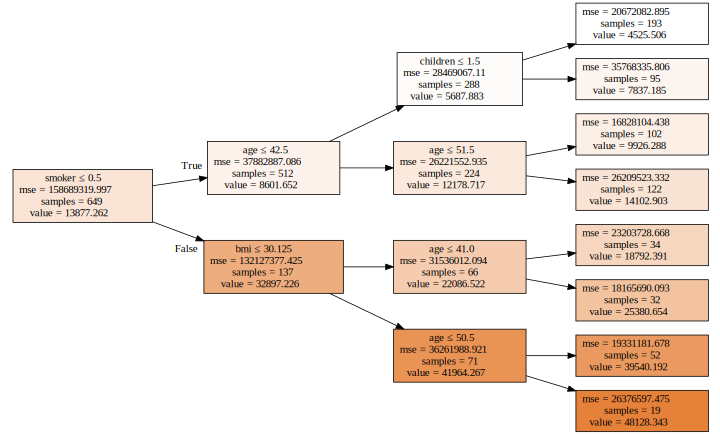

In [20]:
m2 = RandomForestRegressor(n_estimators=10, max_depth=3, bootstrap=True, n_jobs=-1)
m2.fit(df_tra.drop(['charges'], axis=1), df_tra.charges)

draw_tree(m2.estimators_[4], df_tra.drop(['charges'], axis=1), precision=3)

I can use the dictionary translation (created by numericalise_cats()) to look up what the categorical variables mean

In [21]:
translation

{'sex': {0: 'female', 1: 'male'},
 'smoker': {0: 'no', 1: 'yes'},
 'region': {0: 'northeast', 1: 'northwest', 2: 'southeast', 3: 'southwest'}}

In [22]:
# A preview: feature importances (will return to this later)

m2 = RandomForestRegressor(n_estimators=50, max_depth=5, bootstrap=True, n_jobs=-1, oob_score=True)
m2.fit(df_tra.drop(['charges'], axis=1), df_tra.charges)
print(m2.score(df_tra.drop(['charges'], axis=1), df_tra['charges']))
list(zip(m2.feature_importances_, df_tra.drop(['charges'], axis=1).columns))

0.8872172169046386


[(0.12505422122667456, 'age'),
 (0.00025893560327115754, 'sex'),
 (0.1802185360369287, 'bmi'),
 (0.010054378143144273, 'children'),
 (0.6805038885865939, 'smoker'),
 (0.003910040403387451, 'region')]

### Draw a tree using the inbuilt approach from scikit-learn

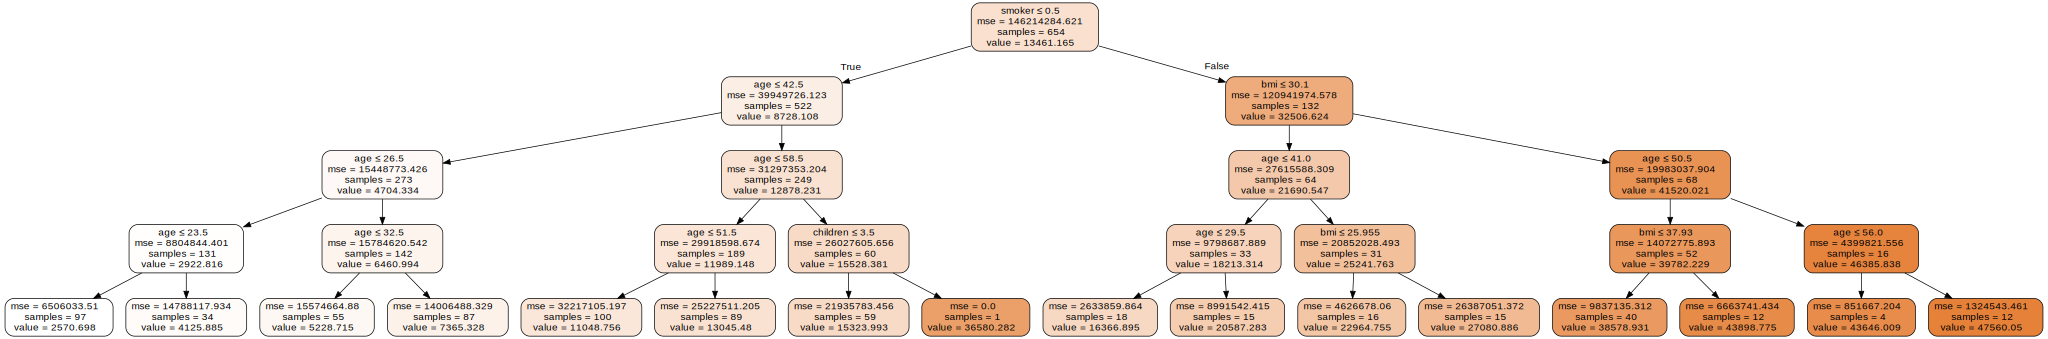

In [23]:
from sklearn import tree 
from sklearn.datasets import load_iris

m2 = RandomForestRegressor(n_estimators=10, max_depth=4, bootstrap=True, n_jobs=-1)
m2.fit(df_tra.drop(['charges'], axis=1), df_tra.charges)

dot_data = tree.export_graphviz(m2.estimators_[0], out_file=None, 
                                feature_names=df_tra.drop(['charges'], axis=1).columns,  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  

graph 
# graph.render("iris")  run this to export this as a PDF file

### Excursion: Draw a tree using the inbuilt approach from scikit-learn

In [24]:
from sklearn.datasets import load_iris
from sklearn import tree
iris = load_iris()
X, y = iris.data, iris.target
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

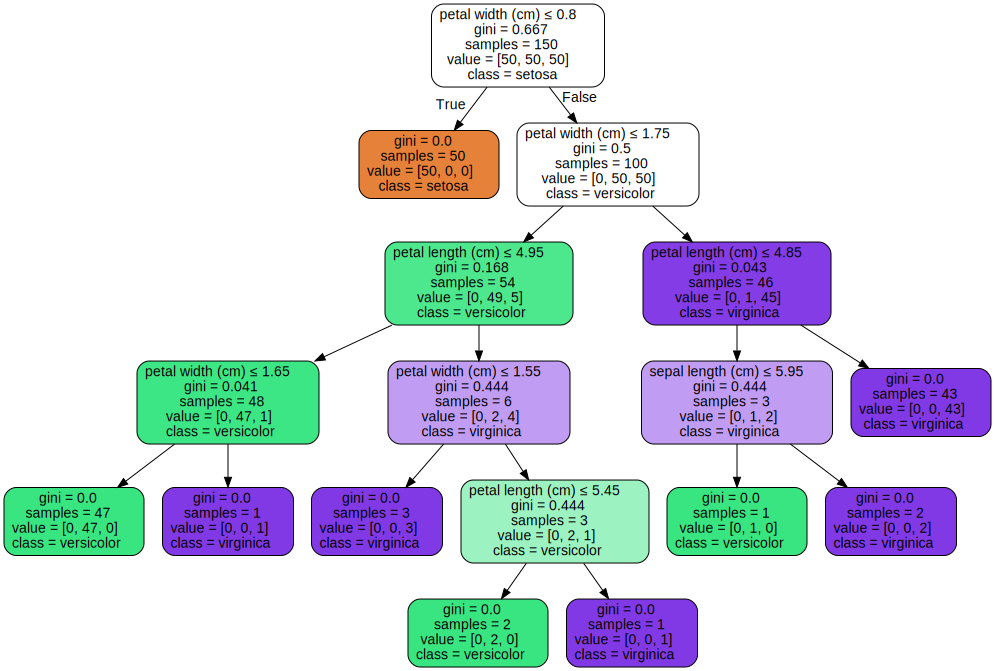

In [25]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=iris.feature_names,  
                                class_names=iris.target_names,  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  

graph 
# graph.render("iris")  run this to export this as a PDF file

## 3. Interpreting the random forest, part I (feature importances)